# Predicting GRN with co-expression method
Reasoning: if a TF is highly expressed together with a target gene, then it should be predictive of said gene. So we try to construct a matrix with r squared value as entry between tf_i gene_j

In [1]:
# Import stuff
import pandas as pd
import numpy as np

In [2]:
# Get expression data
ko_df = pd.read_csv('../dataset/yeast_networks/expression/KO.txt', sep='\t').set_index('Gene')
nv_df = pd.read_csv('../dataset/yeast_networks/expression/NatVar.txt', sep='\t').set_index('Gene')
stress_df = pd.read_csv('../dataset/yeast_networks/expression/Stress.txt', sep='\t').set_index('Name')

# Get Transcription Factors
ko_tf = pd.read_csv('../dataset/yeast_networks/expression/KO_TF_names.txt', sep='\t', header=None)
ko_tf.columns = ['TF']

nv_tf = pd.read_csv('../dataset/yeast_networks/expression/NatVar_TF_names.txt', sep='\t', header=None)
nv_tf.columns = ['TF']

stress_tf = pd.read_csv('../dataset/yeast_networks/expression/Stress_TF_names.txt', sep='\t', header=None)
stress_tf.columns = ['TF']

# Note that there are different gene list for each df, so we will use ko as test for now.

In [57]:
# Get pearsonr matrix for expression df
def pearsonr_method(exp_df, tf_list):
    
    '''
    Get GRN through pearsonr method (If high absolute pearsonr value, there is an edge between the tf and gene)
    '''
 
    # Generate pearsonr matrix
    pearsonr_mat = np.corrcoef(exp_df)

    # Get the TF as rows
    tf_filter = exp_df.index.isin(tf_list.loc[:, 'TF'])
    pearsonr_mat = pearsonr_mat[tf_filter, :]
    
    # Flatten matrix 
    pearsonr_flat = pearsonr_mat.flatten(order='C')
    flat_label = []
    
    for tf_name in exp_df.index[tf_filter]:   
        for target_gene in exp_df.index:
            flat_label.append((tf_name, target_gene))
    
    flat_label = np.array(flat_label)
    
    # Remove entries with TF_Name -> same TF_Name
    
    pearsonr_flat = pearsonr_flat[~(flat_label[:, 0] == flat_label[:, 1])]
    flat_label = flat_label[~(flat_label[:, 0] == flat_label[:, 1])]
    
    new_flat_label = []
    for label in flat_label:
        new_flat_label.append(label[0] + '->' + label[1])
    # We treat this pearsonr_flat like an output value of a sigmoid probability function
    pearsonr_flat = abs(pearsonr_flat)
    return pearsonr_flat, np.array(new_flat_label)
    

In [58]:
ko_pearsonr_flat, ko_flat_label = pearsonr_method(ko_df, ko_tf)

In [106]:
def make_gold_truth(gold_file, pearsonr_flat, flat_label):
    '''
    Function to get the values for existing edges (1 for exist and 0 and not)
    '''
    
    gold_df = pd.read_csv(gold_file, sep = '\t', header = None, names = ['Regulator', 'Target']) 
    gold_edges = gold_df.loc[:, 'Regulator'] + '->' + gold_df.loc[:, 'Target']
    
    truth_flat = np.zeros(len(pearsonr_flat))
    
    truth_flat[pd.Series(flat_label).isin(gold_edges).values] = 1
    
    
    return truth_flat

In [108]:
ko_truth = make_gold_truth('../dataset/yeast_networks/gold/MacIsaac2.KO.txt', ko_pearsonr_flat, ko_flat_label)

In [112]:
# Get roc curve
from sklearn.metrics import roc_curve
fpr, tpr, ths  = roc_curve(ko_truth, ko_pearsonr_flat)

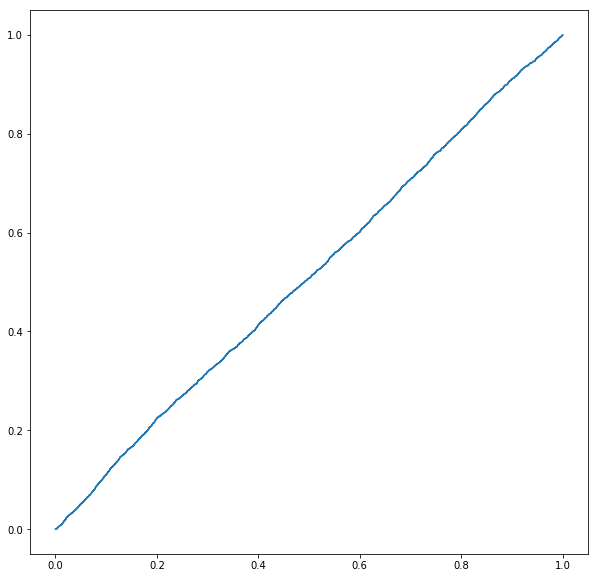

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr)
plt.plot(np.arange(0, 1), np.arange(0,1))
plt.show()